# Week 02 - Deep Learning Repetition

## Deeper Model

As a final step to improve model performance, let us tackle model complexity. So far, the models we have been using were quite simple, either a feed-forward neural network or a basic CNN.

In this notebook, we will increase the **model complexity** by adding more layers to the CNN. These additional layers should enhance the model's capacity and capability to recognize digits that differ from those in the training dataset (i.e., at the outer edges of the data distribution).

The final test will be your hand-written digits, but let's proceed step-by-step. 📈

In [1]:
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tqdm.notebook import tqdm
from pathlib import Path
import shutil
import onnxruntime

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device.upper()}")

Using CPU


## Load the MNIST Dataset 

### Data Augmentation

There are a few options to augment the image data:

- Randomly crop the image: RandomCrop(Output Image Size, Padding of the Image)

    `torchvision.transforms.RandomCrop(28, 4)`

- Randomly rotate the image: RandomRotation(Max Rotation in Degrees)

    `torchvision.transforms.RandomRotation(5)`

- Randomly blur the image: GaussianBlur(Kernel Size) -> larger kernel means more blur

    `torchvision.transforms.GaussianBlur(kernel_size = (5,5))`

- Randomly change the colors in the image: ColorJitter(Brightness, Contrast, Saturation, Hue)

    `torchvision.transforms.ColorJitter(brightness=(0.5,1.5), contrast=3, saturation=(0.3,1.5), hue=(-0.1,0.1))`


In [2]:
# Define the transformation
image_transformation = transforms.Compose(
    [
        # '''TODO: Insert your data augmentation(s) from the last notebook.'''
        transforms.GaussianBlur(kernel_size=(5, 5)),
        transforms.RandomRotation(15),
        transforms.RandomCrop(28, 4),
        transforms.ColorJitter(
            brightness=(0.5, 1.5), contrast=3, saturation=(0.3, 1.5), hue=(-0.1, 0.1)
        ),
        transforms.ToTensor(),
    ]
)

In [3]:
mnist_directory = Path.cwd() / ".mnist_data" / "3_deeper"

# Delete the existing MNIST data directory if it exists
if mnist_directory.exists() and mnist_directory.is_dir():
    shutil.rmtree(mnist_directory)

In [4]:
# Load the MNIST dataset
dataset_mnist_train = datasets.MNIST(
    mnist_directory, train=True, download=True, transform=image_transformation
)
dataset_mnist_test = datasets.MNIST(
    mnist_directory, train=False, download=True, transform=image_transformation
)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.80MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 313kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.38MB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


Split the training dataset into training and validation sets using PyTorch's `random_split` function.

In [5]:
# Split the training dataset into training and validation sets
train_size = int(0.8 * len(dataset_mnist_train))
val_size = len(dataset_mnist_train) - train_size
dataset_mnist_train, dataset_mnist_val = random_split(
    dataset_mnist_train, [train_size, val_size]
)

The `DataLoader` class is useful to create batch sizes of the data and to shuffle it.

In [6]:
# Create DataLoaders
train_loader = DataLoader(dataset_mnist_train, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset_mnist_val, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset_mnist_test, batch_size=64, shuffle=True)

## Visualize the Dataset

Let us briefly look at the data 👀

In [7]:
images, labels = next(iter(train_loader))

print(f"Image Batch shape: {images.shape}")
print(f"Label Batch shape: {labels.shape}")

Image Batch shape: torch.Size([64, 1, 28, 28])
Label Batch shape: torch.Size([64])


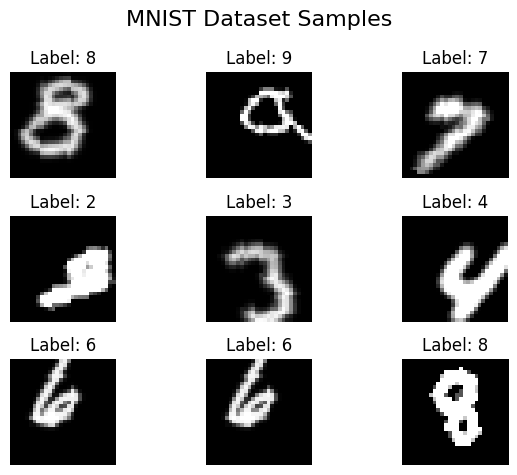

In [8]:
fig, axes = plt.subplots(3, 3)
fig.suptitle("MNIST Dataset Samples", fontsize=16)

for ax in axes.flat:
    idx = torch.randint(0, len(images), (1,))
    ax.imshow(images[idx].squeeze(), cmap="gray")
    ax.set_title(f"Label: {labels[idx].item()}")
    ax.axis("off")

plt.tight_layout()
plt.show()

## Model Architecture

The model architecture can be adjusted with one or more of the following augmentation techniques.

Use more/fewer Conv2d layers:
```Python
torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
torch.nn.ReLU(),
```

Use more/fewer Dropout layers:
```Python
torch.nn.Dropout2d(p=0.2),
torch.nn.Dropout(p=0.2)
```

Use more/fewer Linear (fully connected) layers:
```Python
torch.nn.Linear(in_features=512, out_features=128),
torch.nn.ReLU(),
```

Add Max Pooling layers:
```Python
torch.nn.MaxPool2d(kernel_size=2, stride=2),
```

Add Batch Normalization layers:
```Python
torch.nn.BatchNorm2d(num_features=16),
torch.nn.BatchNorm1d(num_features=512),
```

In [9]:
# '''TODO: Create a more complex CNN architecture using some of the above layers,
# and/or adjust the number of filters, kernel_size, padding, etc.'''

model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
    nn.BatchNorm2d(num_features=16),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
    nn.BatchNorm2d(num_features=32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(in_features=32 * 7 * 7, out_features=128),
    nn.BatchNorm1d(num_features=128),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=128, out_features=64),
    nn.BatchNorm1d(num_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=10),
)

In [10]:
print(summary(model=model, input_size=images.shape))
model_output = model(images)
print(f"Model output shape: {model_output.shape}")

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [64, 10]                  --
├─Conv2d: 1-1                            [64, 16, 28, 28]          160
├─BatchNorm2d: 1-2                       [64, 16, 28, 28]          32
├─ReLU: 1-3                              [64, 16, 28, 28]          --
├─MaxPool2d: 1-4                         [64, 16, 14, 14]          --
├─Conv2d: 1-5                            [64, 32, 14, 14]          4,640
├─BatchNorm2d: 1-6                       [64, 32, 14, 14]          64
├─ReLU: 1-7                              [64, 32, 14, 14]          --
├─MaxPool2d: 1-8                         [64, 32, 7, 7]            --
├─Flatten: 1-9                           [64, 1568]                --
├─Linear: 1-10                           [64, 128]                 200,832
├─BatchNorm1d: 1-11                      [64, 128]                 256
├─ReLU: 1-12                             [64, 128]                 --
├─Dro

## Model Training

Training Epoch 1/10:   0%|          | 0/750 [00:00<?, ?it/s]

After batch 100: Train Loss: 1.8079


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 100: Validation Loss: 1.2487
After batch 200: Train Loss: 1.4301


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 200: Validation Loss: 0.8123
After batch 300: Train Loss: 1.2121


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 300: Validation Loss: 0.5612
After batch 400: Train Loss: 1.0704


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 400: Validation Loss: 0.4944
After batch 500: Train Loss: 0.9803


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 500: Validation Loss: 0.4437
After batch 600: Train Loss: 0.9138


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 600: Validation Loss: 0.4033
After batch 700: Train Loss: 0.8613


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 700: Validation Loss: 0.3919
Epoch 1 - Train Loss: 0.8394


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1 - Validation Loss: 0.3759


Training Epoch 2/10:   0%|          | 0/750 [00:00<?, ?it/s]

After batch 100: Train Loss: 0.4892


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 100: Validation Loss: 0.3318
After batch 200: Train Loss: 0.4839


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 200: Validation Loss: 0.3038
After batch 300: Train Loss: 0.4782


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 300: Validation Loss: 0.3000
After batch 400: Train Loss: 0.4633


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 400: Validation Loss: 0.2796
After batch 500: Train Loss: 0.4551


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 500: Validation Loss: 0.3084
After batch 600: Train Loss: 0.4492


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 600: Validation Loss: 0.2954
After batch 700: Train Loss: 0.4420


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 700: Validation Loss: 0.3185
Epoch 2 - Train Loss: 0.4414


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2 - Validation Loss: 0.2553


Training Epoch 3/10:   0%|          | 0/750 [00:00<?, ?it/s]

After batch 100: Train Loss: 0.3834


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 100: Validation Loss: 0.2944
After batch 200: Train Loss: 0.3814


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 200: Validation Loss: 0.2420
After batch 300: Train Loss: 0.3837


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 300: Validation Loss: 0.2399
After batch 400: Train Loss: 0.3825


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 400: Validation Loss: 0.3175
After batch 500: Train Loss: 0.3770


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 500: Validation Loss: 0.2370
After batch 600: Train Loss: 0.3748


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 600: Validation Loss: 0.2324
After batch 700: Train Loss: 0.3686


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 700: Validation Loss: 0.2210
Epoch 3 - Train Loss: 0.3692


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 3 - Validation Loss: 0.2366


Training Epoch 4/10:   0%|          | 0/750 [00:00<?, ?it/s]

After batch 100: Train Loss: 0.3569


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 100: Validation Loss: 0.2507
After batch 200: Train Loss: 0.3436


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 200: Validation Loss: 0.2226
After batch 300: Train Loss: 0.3395


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 300: Validation Loss: 0.2439
After batch 400: Train Loss: 0.3340


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 400: Validation Loss: 0.2115
After batch 500: Train Loss: 0.3308


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 500: Validation Loss: 0.2045
After batch 600: Train Loss: 0.3322


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 600: Validation Loss: 0.2121
After batch 700: Train Loss: 0.3296


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 700: Validation Loss: 0.2054
Epoch 4 - Train Loss: 0.3270


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 4 - Validation Loss: 0.2454


Training Epoch 5/10:   0%|          | 0/750 [00:00<?, ?it/s]

After batch 100: Train Loss: 0.3190


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 100: Validation Loss: 0.2139
After batch 200: Train Loss: 0.3117


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 200: Validation Loss: 0.1981
After batch 300: Train Loss: 0.3102


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 300: Validation Loss: 0.1971
After batch 400: Train Loss: 0.3088


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 400: Validation Loss: 0.1889
After batch 500: Train Loss: 0.3061


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 500: Validation Loss: 0.2126
After batch 600: Train Loss: 0.3056


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 600: Validation Loss: 0.2023
After batch 700: Train Loss: 0.3037


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 700: Validation Loss: 0.1994
Epoch 5 - Train Loss: 0.3040


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 5 - Validation Loss: 0.1810


Training Epoch 6/10:   0%|          | 0/750 [00:00<?, ?it/s]

After batch 100: Train Loss: 0.2963


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 100: Validation Loss: 0.1820
After batch 200: Train Loss: 0.2913


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 200: Validation Loss: 0.1852
After batch 300: Train Loss: 0.2930


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 300: Validation Loss: 0.2121
After batch 400: Train Loss: 0.2885


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 400: Validation Loss: 0.1717
After batch 500: Train Loss: 0.2860


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 500: Validation Loss: 0.1667
After batch 600: Train Loss: 0.2836


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 600: Validation Loss: 0.2003
After batch 700: Train Loss: 0.2839


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 700: Validation Loss: 0.1734
Epoch 6 - Train Loss: 0.2829


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 6 - Validation Loss: 0.1763


Training Epoch 7/10:   0%|          | 0/750 [00:00<?, ?it/s]

After batch 100: Train Loss: 0.2851


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 100: Validation Loss: 0.1949
After batch 200: Train Loss: 0.2763


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 200: Validation Loss: 0.1615
After batch 300: Train Loss: 0.2758


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 300: Validation Loss: 0.1695
After batch 400: Train Loss: 0.2713


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 400: Validation Loss: 0.1694
After batch 500: Train Loss: 0.2727


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 500: Validation Loss: 0.1620
After batch 600: Train Loss: 0.2704


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 600: Validation Loss: 0.1570
After batch 700: Train Loss: 0.2691


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 700: Validation Loss: 0.1714
Epoch 7 - Train Loss: 0.2688


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 7 - Validation Loss: 0.1498


Training Epoch 8/10:   0%|          | 0/750 [00:00<?, ?it/s]

After batch 100: Train Loss: 0.2568


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 100: Validation Loss: 0.1684
After batch 200: Train Loss: 0.2645


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 200: Validation Loss: 0.1601
After batch 300: Train Loss: 0.2616


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 300: Validation Loss: 0.1599
After batch 400: Train Loss: 0.2604


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 400: Validation Loss: 0.1793
After batch 500: Train Loss: 0.2599


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 500: Validation Loss: 0.1480
After batch 600: Train Loss: 0.2581


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 600: Validation Loss: 0.1766
After batch 700: Train Loss: 0.2559


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 700: Validation Loss: 0.1943
Epoch 8 - Train Loss: 0.2555


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 8 - Validation Loss: 0.1905


Training Epoch 9/10:   0%|          | 0/750 [00:00<?, ?it/s]

After batch 100: Train Loss: 0.2573


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 100: Validation Loss: 0.1652
After batch 200: Train Loss: 0.2502


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 200: Validation Loss: 0.1426
After batch 300: Train Loss: 0.2492


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 300: Validation Loss: 0.1618
After batch 400: Train Loss: 0.2514


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 400: Validation Loss: 0.1543
After batch 500: Train Loss: 0.2527


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 500: Validation Loss: 0.1568
After batch 600: Train Loss: 0.2529


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 600: Validation Loss: 0.1514
After batch 700: Train Loss: 0.2501


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 700: Validation Loss: 0.1531
Epoch 9 - Train Loss: 0.2504


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 9 - Validation Loss: 0.1376


Training Epoch 10/10:   0%|          | 0/750 [00:00<?, ?it/s]

After batch 100: Train Loss: 0.2509


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 100: Validation Loss: 0.1398
After batch 200: Train Loss: 0.2370


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 200: Validation Loss: 0.1532
After batch 300: Train Loss: 0.2339


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 300: Validation Loss: 0.1500
After batch 400: Train Loss: 0.2376


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 400: Validation Loss: 0.1575
After batch 500: Train Loss: 0.2354


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 500: Validation Loss: 0.1496
After batch 600: Train Loss: 0.2381


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 600: Validation Loss: 0.1535
After batch 700: Train Loss: 0.2395


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

After batch 700: Validation Loss: 0.1455
Epoch 10 - Train Loss: 0.2390


Validation:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 10 - Validation Loss: 0.1441


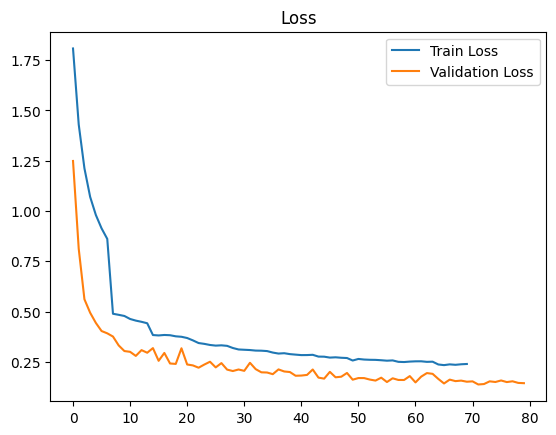

In [11]:
EPOCHS = 10
LEARNING_RATE = 0.001
BATCH_INTERVAL = 100  # Calculate losses after every 100 batches

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()

train_loss_history = []
val_loss_history = []

model.to(device)

for epoch in range(EPOCHS):
    model.train()
    running_train_loss = 0.0
    for batch_idx, (image_batch, output_batch) in enumerate(
        tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{EPOCHS}"), start=1
    ):
        image_batch, output_batch = image_batch.to(device), output_batch.to(device)
        optimizer.zero_grad()
        model_output = model(image_batch)
        loss = loss_function(model_output, output_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

        if (batch_idx) % BATCH_INTERVAL == 0:
            avg_train_loss = running_train_loss / (batch_idx)
            train_loss_history.append(avg_train_loss)
            print(f"After batch {batch_idx}: Train Loss: {avg_train_loss:.4f}")

            # Evaluate validation loss
            model.eval()
            running_val_loss = 0.0
            with torch.no_grad():
                for val_image_batch, val_output_batch in tqdm(
                    val_loader, desc="Validation"
                ):
                    val_image_batch, val_output_batch = (
                        val_image_batch.to(device),
                        val_output_batch.to(device),
                    )
                    val_model_output = model(val_image_batch)
                    val_loss = loss_function(val_model_output, val_output_batch)
                    running_val_loss += val_loss.item()
            avg_val_loss = running_val_loss / len(val_loader)
            val_loss_history.append(avg_val_loss)
            print(f"After batch {batch_idx}: Validation Loss: {avg_val_loss:.4f}")
            model.train()  # Switch back to training mode

    avg_epoch_train_loss = running_train_loss / len(train_loader)
    print(f"Epoch {epoch+1} - Train Loss: {avg_epoch_train_loss:.4f}")

    # Evaluate validation loss at the end of each epoch
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for val_image_batch, val_output_batch in tqdm(val_loader, desc="Validation"):
            val_model_output = model(val_image_batch)
            val_loss = loss_function(val_model_output, val_output_batch)
            running_val_loss += val_loss.item()
    avg_epoch_val_loss = running_val_loss / len(val_loader)
    val_loss_history.append(avg_epoch_val_loss)
    print(f"Epoch {epoch+1} - Validation Loss: {avg_epoch_val_loss:.4f}")

plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.title("Loss")
plt.legend()
plt.show()

## Test the Model

Test the freshly trained model with a randomly drawn image from the dataset.

In [12]:
def load_onnx_model(path_to_model: Path):
    if path_to_model is None:
        raise ValueError("Path must be provided if onnx is True")
    return onnxruntime.InferenceSession(
        str(path_to_model), providers=["CPUExecutionProvider"]
    )


def predict_digit(
    input_tensor: torch.Tensor,
    model: torch.nn.Module = None,
    onnx: bool = False,
    onnx_model_path: Path = None,
) -> tuple[int, float]:
    if onnx:
        model_session = load_onnx_model(onnx_model_path)
        onnx_predictions = model_session.run(None, {"image": input_tensor})
        predictions = torch.tensor(np.array(onnx_predictions))
    else:
        predictions = model(input_tensor)

    predicted_number = torch.argmax(predictions)
    probabilities = F.softmax(predictions.clone().detach(), dim=-1).numpy().squeeze()
    confidence = probabilities[predicted_number]
    return predicted_number.item(), confidence

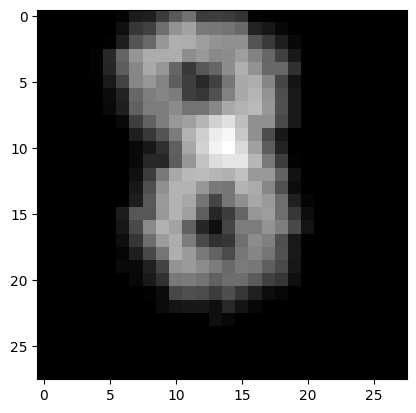

Predicted : 8 - Confidence: 98.12%
True label: 8


In [13]:
sampling_idx = torch.randint(0, len(images), (1,))
test_img = images[sampling_idx]
test_label = labels[sampling_idx]
plt.imshow(test_img.numpy().squeeze(), cmap="grey")
plt.show()
predicted_number, confidence = predict_digit(test_img, model)
print(f"Predicted : {predicted_number} - Confidence: {100*confidence:.2f}%")
print(f"True label: {test_label.item()}")

### Metrics

Does it look good?

Since this is just one image from the **training** dataset, we need to evaluate how the model performs on data it has never seen before. This is where the **test** dataset comes in. In the following cell, we calculate various metrics to evaluate the model's performance.

The metrics we will calculate are Accuracy, Recall, F1 score, and Support:

- **Accuracy**: The ratio of correctly predicted instances to the total instances. It gives an overall measure of how well the model is performing.
- **Recall**: The ratio of correctly predicted positive observations to all the observations in the actual class. It tells us how well the model can identify positive instances.
- **F1 Score**: The weighted average of Precision and Recall. It is useful when you need a balance between Precision and Recall.
- **Support**: The number of actual occurrences of the class in the dataset. It helps in understanding the distribution of the dataset.

When interpreting these metrics, keep in mind:
- **Accuracy** can be misleading if the dataset is imbalanced.
- **Recall** is crucial when the cost of false negatives is high.
- **F1 Score** is useful when you need to balance Precision and Recall.
- **Support** helps in understanding the context of the other metrics.


Evaluating the model on the Test set:   0%|          | 0/157 [00:00<?, ?it/s]

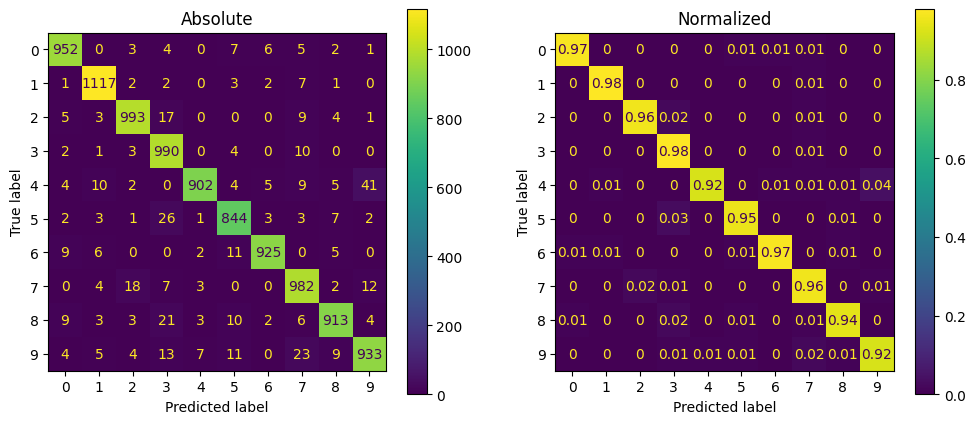

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       980
           1       0.97      0.98      0.98      1135
           2       0.97      0.96      0.96      1032
           3       0.92      0.98      0.95      1010
           4       0.98      0.92      0.95       982
           5       0.94      0.95      0.95       892
           6       0.98      0.97      0.97       958
           7       0.93      0.96      0.94      1028
           8       0.96      0.94      0.95       974
           9       0.94      0.92      0.93      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.95      0.95     10000
weighted avg       0.96      0.96      0.96     10000



In [14]:
model.to(device)
model.eval()

test_predicted_output = []
test_true_output = []

with torch.no_grad():
    for batch_idx, (image_batch, output_batch) in enumerate(
        tqdm(test_loader, desc="Evaluating the model on the Test set")
    ):
        image_batch, output_batch = image_batch.to(device), output_batch.to(device)
        model_output = model(image_batch)
        predicted_numbers = torch.argmax(model_output, dim=1)
        test_predicted_output.extend(predicted_numbers.cpu().numpy())
        test_true_output.extend(output_batch.cpu().numpy())

cm_abs = confusion_matrix(
    test_true_output, test_predicted_output, labels=[i for i in range(10)]
)
cm_norm = confusion_matrix(
    test_true_output,
    test_predicted_output,
    labels=[i for i in range(10)],
    normalize="true",
)
cm_round = np.around(cm_norm, 2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

disp_abs = ConfusionMatrixDisplay(
    confusion_matrix=cm_abs, display_labels=[i for i in range(10)]
)
disp_norm = ConfusionMatrixDisplay(
    confusion_matrix=cm_round, display_labels=[i for i in range(10)]
)

classification_report_test = classification_report(
    test_true_output, test_predicted_output, labels=[i for i in range(10)]
)

disp_abs.plot(ax=ax1)
ax1.set_title("Absolute")
ax1.grid(False)

disp_norm.plot(ax=ax2)
ax2.set_title("Normalized")
ax2.grid(False)
plt.show()

print(classification_report_test)

The metrics look very well again. But does the model also perform well on your hand-written digits? Let us find out!

## Model Export

In [15]:
FILE_NAME = "./3_deeper_mnist_model.onnx"

MODEL_FOLDER = Path.cwd() / "models"
MODEL_PATH = MODEL_FOLDER / FILE_NAME

# Create the directory if it doesn't exist
if not MODEL_FOLDER.exists():
    MODEL_FOLDER.mkdir(parents=True, exist_ok=True)
    print(f"Directory '{MODEL_FOLDER}' created.")
else:
    print(f"Directory '{MODEL_FOLDER}' already exists.")

Directory 'c:\Users\TobiasRothlin\Documents\Python_Projects\ComputerVisionTurtorial\models' already exists.


In [16]:
# Save the model
model.eval()
image = images[0].unsqueeze(0)
torch.onnx.export(
    model, image, MODEL_PATH, input_names=["image"], output_names=["digit"]
)

print(f"Model exported in ONNX format to: {MODEL_PATH}")

Model exported in ONNX format to: c:\Users\TobiasRothlin\Documents\Python_Projects\ComputerVisionTurtorial\models\3_deeper_mnist_model.onnx


## Real-world Data

Most tutorials would just finish with the above evaluation. After all, the metrics look quite good, the majority of the manually provided samples to the model are correctly classified; what more do you want?

What is mostly missing, but what is the most common problem in practice, is, that there are real-world cases with real-world data. The model is performing quite well, but what if you provide completely novel hand-written digits to it that is maybe not nicely centred, or is drawn with a different pencil width, or rotated, etc.

In the following section, we add this real-world scenario by letting you draw your own hand-written digits and test your trained models against this custom dataset.

### Single Digit

To create a single digit that can be run in the `Real-World Model Inference` below:
1. Open the drawing tool to create hand-written digits yourself by running the next cell
1. Select the model you just created
1. Draw a digit
1. Click on 'Classify' to see how well the model predicts
1. Close the tool (or try more digits)

#### Custom Digits Test Dataset

To create a suite of digits ranging from 0 to 9 that can be run in the `Real-World Digits Comparison` below:
1. Open the drawing tool to create hand-written digits yourself by running the next cell
1. Click on `Create Custom Test Set`
1. Draw the digit that is prompted
1. Click on `Save and Next`
1. Once done you can change any drawn number by selecting it from the dropdown

In [17]:
!python src/model_test_drawing.py

Predicted number: 6, Confidence: 0.9880
Predicted number: 7, Confidence: 0.9983
Predicted number: 8, Confidence: 0.9999
Predicted number: 1, Confidence: 0.7815
Predicted number: 0, Confidence: 0.9989
Predicted number: 0, Confidence: 0.9989
Predicted number: 2, Confidence: 0.9993


### Real-World Model Inference

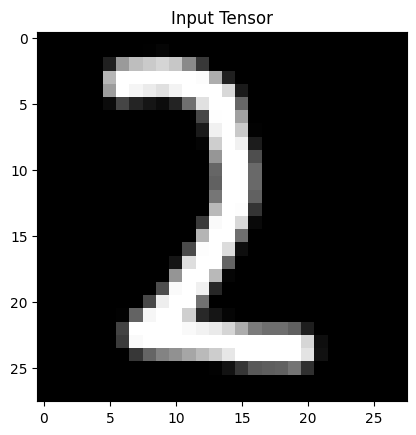

PyTorch model prediction: 2 - Confidence: 99.93%
ONNX model prediction:    2 - Confidence: 99.93%


In [18]:
assert (
    Path.cwd() / "handwriting" / "my_digit.npy"
).exists(), "Draw and classify a digit first."
image_input_tensor = np.load("handwriting/my_digit.npy")

plt.cla()
plt.imshow(image_input_tensor[0].squeeze(), cmap="grey")
plt.title("Input Tensor")
plt.show()

try:
    model.eval()
    pt_predicted_number, pt_confidence = predict_digit(
        torch.tensor(image_input_tensor), model
    )
    print(
        f"PyTorch model prediction: {pt_predicted_number} - Confidence: {100*pt_confidence:.2f}%"
    )
except NameError:
    print("No PyTorch model present, skipping...")

onnx_predicted_number, onnx_confidence = predict_digit(
    image_input_tensor, onnx=True, onnx_model_path=MODEL_PATH
)
print(
    f"ONNX model prediction:    {onnx_predicted_number} - Confidence: {100*onnx_confidence:.2f}%"
)

#### Real-World Digits Comparison

The plot lets you compare the performance of all the models from the following notebooks (they will have the same output, just with their model).

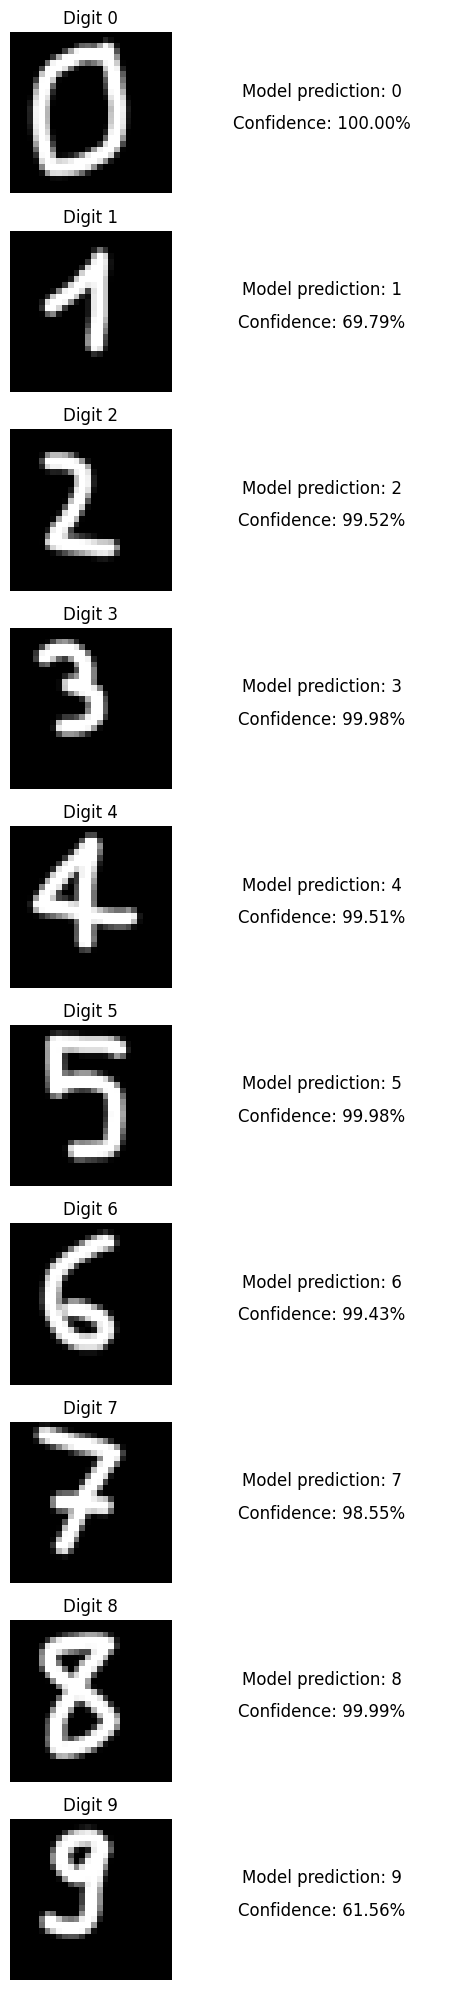

In [19]:
assert (
    Path.cwd() / "handwriting" / "digit_0.npy"
).exists(), "Draw and classify a digit first."
directory_path = Path("handwriting/")

fig, axes = plt.subplots(10, 2, figsize=(5, 20))

for i in range(10):
    file_path = directory_path / f"digit_{i}.npy"
    image_input_tensor = np.load(file_path)

    axes[i, 0].imshow(image_input_tensor.squeeze(), cmap="gray")
    axes[i, 0].set_title(f"Digit {i}")
    axes[i, 0].axis("off")

    onnx_predicted_number, onnx_confidence = predict_digit(
        image_input_tensor, onnx=True, onnx_model_path=MODEL_PATH
    )

    axes[i, 1].text(
        0.5, 0.6, f"Model prediction: {onnx_predicted_number}", fontsize=12, ha="center"
    )
    axes[i, 1].text(
        0.5, 0.4, f"Confidence: {100*onnx_confidence:.2f}%", fontsize=12, ha="center"
    )
    axes[i, 1].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()

Finally, the model seems to predict the correct digit, and with high confidence 👏👏👏